Files already downloaded and verified
Files already downloaded and verified


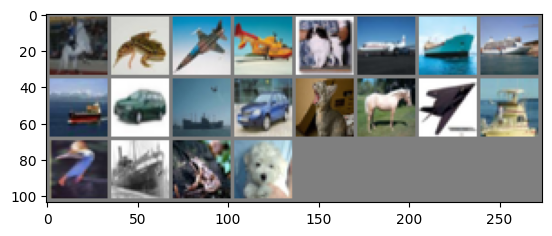

Epoch [1/10], Step [2000/2500], Loss: 1.8558
Epoch [2/10], Step [2000/2500], Loss: 1.6164
Epoch [3/10], Step [2000/2500], Loss: 1.2360
Epoch [4/10], Step [2000/2500], Loss: 1.2636
Epoch [5/10], Step [2000/2500], Loss: 1.3984
Epoch [6/10], Step [2000/2500], Loss: 1.0764
Epoch [7/10], Step [2000/2500], Loss: 0.9821
Epoch [8/10], Step [2000/2500], Loss: 1.0854
Epoch [9/10], Step [2000/2500], Loss: 0.6974
Epoch [10/10], Step [2000/2500], Loss: 0.8561
Finished Training
Accuracy of the network: 63.92 %
Accuracy of plane: 64.7 %
Accuracy of car: 76.9 %
Accuracy of bird: 54.1 %
Accuracy of cat: 51.1 %
Accuracy of deer: 51.2 %
Accuracy of dog: 49.8 %
Accuracy of frog: 77.0 %
Accuracy of horse: 71.3 %
Accuracy of ship: 76.3 %
Accuracy of truck: 66.8 %


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('mps')

# Hyper-parameters
num_epochs = 10
batch_size = 20
learning_rate = 0.01

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
# Min of input image = 0 -> 0-0.5 = -0.5 -> gets divided by 0.5 std -> -1
# Max of input image = 255 -> toTensor -> 1 -> (1 - 0.5) / 0.5 -> 1
# so it transforms your data in a range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Hard code names

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
#images, labels = dataiter.next()
images, labels = next(iter(train_loader))


# show images
imshow(torchvision.utils.make_grid(images))

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
                                    # -> n, 3, 32, 32
        x = self.conv1(x)           # -> n, 6, 28, 28
        x = F.relu(x)
        x = self.pool(x)            # -> n, 6, 14, 14
        x = self.conv2(x)           # -> n, 16, 10, 10
        x = F.relu(x)
        x = self.pool(x)            # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)  # -> n, 400
        x = self.fc1(x)             # -> n, 120
        x = F.relu(x)
        x = self.fc2(x)             # -> n, 84
        x = F.relu(x)
        x = self.fc3(x)             # -> n, 10
        return x

model = ConvNet().to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        l = loss(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {l.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')